# 📈 DS-02: Detección de estacionalidad en demanda

Análisis de series temporales para identificar patrones y estacionalidad en órdenes.

---
id: "DS-02"
title: "Detección de estacionalidad y tendencias en demanda por canal"
specialty: "Data Science"
process: "Plan"
level: "Intermediate"
tags: ["seasonality", "forecast", "timeseries", "channels"]
estimated_time_min: 45
---

## 📦 Instalación de Librerías Necesarias

**Antes de ejecutar este notebook, asegúrate de tener instaladas todas las dependencias.**

### Opción 1: Instalación dentro del notebook
Ejecuta la siguiente celda para instalar las librerías necesarias:

```python
%pip install pandas numpy matplotlib seaborn plotly scikit-learn statsmodels scipy
```

### Opción 2: Instalación desde terminal
Si prefieres instalar desde la terminal, ejecuta:

```bash
# PowerShell o CMD
pip install pandas numpy matplotlib seaborn plotly scikit-learn statsmodels scipy

# O si usas el proyecto completo con pyproject.toml
pip install -e .[core,notebooks]
```

### Librerías requeridas:
- `pandas`: Manipulación y análisis de datos
- `numpy`: Cálculos numéricos y arrays
- `matplotlib`: Visualización estática
- `seaborn`: Visualización estadística avanzada
- `plotly`: Gráficos interactivos (opcional)
- `scikit-learn`: Métricas de evaluación (MAE, RMSE, MAPE)
- `statsmodels`: Descomposición STL, ACF/PACF, tests estadísticos
- `scipy`: Funciones científicas complementarias

---

In [1]:
# ⚙️ Preparación de entorno y rutas
# Si esta celda tarda demasiado o se cuelga:
# 1) Abre la paleta de comandos (Ctrl+Shift+P)
# 2) "Jupyter: Restart Kernel"
# 3) "Run All Above/Below" o ejecuta desde la primera celda

import sys
from pathlib import Path

# Detectar raíz del repo (buscando pyproject.toml o carpeta src)
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()

if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))

print(f"✅ Entorno listo. Raíz del repo: {_repo_root}")

✅ Entorno listo. Raíz del repo: f:\GitHub\supply-chain-data-notebooks


# DS-02: Análisis de Estacionalidad y Tendencias en Demanda

data_path = _repo_root / 'data' / 'raw'
df_orders = pd.read_csv(data_path / 'orders.csv')
**Empresa:** "RetailFlow Analytics" - Cadena de retail omnicanal con 120 tiendas físicas y plataforma eCommerce, facturación anual $280M.

**Situación:** El equipo de S&OP enfrenta desafíos críticos en planificación de demanda:
- **Forecast impreciso:** Error MAPE del 35% en meses con eventos especiales
- **Stockouts:** 18% en temporada alta (Black Friday, Navidad) por subestimación
- **Overstock:** 22% post-temporada por no anticipar caída de demanda
- **Variabilidad por canal:** Online crece 15% mensual, tiendas físicas decrecen 3%
- **Impacto financiero:** $8.2M anuales en costos de inventario excesivo y ventas perdidas

**Objetivo:** Implementar un **sistema de análisis de estacionalidad** que:
- Descomponga series temporales en tendencia, estacionalidad y residuos
- Identifique patrones estacionales por canal (online, retail, wholesale)
- Cuantifique magnitud de picos estacionales (índices de estacionalidad)
- Genere pronósticos ajustados por estacionalidad (reducir MAPE a <20%)

---

## 🎯 Qué - Por qué - Para qué - Cuándo - Cómo

### ❓ ¿QUÉ estamos haciendo?
Construyendo un **sistema de detección y cuantificación de estacionalidad** que:
- **Descompone series temporales:** Usando STL (Seasonal-Trend decomposition using LOESS)
- **Detecta patrones:** Estacionalidad semanal (fin de semana), mensual (quincenas) y anual (temporadas)
- **Cuantifica magnitud:** Índices de estacionalidad (% sobre media anual)
- **Visualiza componentes:** Gráficos de tendencia, estacionalidad y residuos
- **Genera pronósticos:** Forecast baseline ajustado por componente estacional

**Componentes de análisis:**
1. **Tendencia:** Dirección de largo plazo (crecimiento/decrecimiento)
2. **Estacionalidad:** Patrones repetitivos (diario, semanal, mensual, anual)
3. **Residuos:** Variación no explicada (eventos aleatorios, promociones)

### 🔍 ¿POR QUÉ es importante?
- **Precisión de forecast:** Modelos con estacionalidad reducen error 40-60%
- **Optimización de inventario:** Ajustar stock de seguridad por temporada
- **Planificación de capacidad:** Staffing, almacenes, transporte
- **Estrategia comercial:** Timing de promociones alineado con picos naturales

### 🎁 ¿PARA QUÉ sirve?
- **S&OP mejorado:** Planes de demanda más precisos por canal y categoría
- **Gestión de inventario:** Safety stock variable según estacionalidad
- **Pricing dinámico:** Precios premium en temporada alta
- **Marketing efectivo:** Campañas en momentos de mayor receptividad
- **Supply chain resiliente:** Anticipar picos y valles de demanda

### ⏰ ¿CUÁNDO aplicarlo?
- **Ciclo S&OP mensual:** Actualizar pronósticos con últimos datos
- **Pre-temporadas:** Antes de Black Friday, Navidad, Back to School
- **Nuevos SKUs:** Transferir patrones de productos similares
- **Cambios de canal:** Analizar estacionalidad de online vs offline
- **Post-promociones:** Descontar efectos para ver estacionalidad real

### 🛠️ ¿CÓMO lo hacemos?
1. **Preparar datos:** Agregar órdenes por fecha y canal
2. **Descomponer series:** STL para separar tendencia, estacionalidad, residuos
3. **Calcular índices:** Índice estacional (% sobre media)
4. **Detectar patrones:** Autocorrelación, picos recurrentes
5. **Visualizar insights:** Heatmaps estacionales, gráficos de componentes
6. **Generar forecast:** Proyección con componente estacional
7. **Validar precisión:** Backtesting vs datos reales

## 🎯 Contexto del Notebook

### ¿Qué?
Análisis de componentes estacionales y tendencias en series de demanda usando descomposición STL.

### ¿Por qué?
Entender patrones estacionales mejora pronósticos y planificación de inventario (ej: picos en festivos).

### ¿Para qué?
- Ajustar modelos de forecast con componente estacional
- Planificar promociones y abastecimiento
- Identificar SKUs con alta variabilidad

### ¿Cuándo?
Al inicio de ciclo de S&OP, antes de generar pronósticos para el próximo trimestre.

### ¿Cómo?
1. Agregar órdenes por fecha
2. Aplicar STL decomposition
3. Visualizar tendencia, estacionalidad y residuos

In [ ]:
# 📚 CONCEPTO: Librerías especializadas en series temporales
# - statsmodels.tsa.seasonal: Toolkit profesional para descomposición de series temporales
#   * STL: Seasonal-Trend decomposition using LOESS (método robusto, flexible)
#   * seasonal_decompose: Método clásico (aditivo/multiplicativo)
# - statsmodels.graphics.tsaplots: Análisis de autocorrelación (ACF/PACF)
#   * ACF: Autocorrelation Function - mide correlación de serie consigo misma en diferentes lags
#   * PACF: Partial ACF - correlación controlando por lags intermedios

# 💡 INTERPRETACIÓN: ¿Por qué STL sobre seasonal_decompose clásico?
# STL ventajas:
# - Robusto a outliers: usa LOESS (regresión local ponderada)
# - Flexibilidad en estacionalidad: puede cambiar en el tiempo (ej: Black Friday crece cada año)
# - Control fino: parámetros seasonal, trend permiten ajustar suavizado
# seasonal_decompose ventajas:
# - Simplicidad: más fácil de explicar (promedios móviles)
# - Rapidez: computacionalmente más ligero

# 🔍 TÉCNICA: warnings.filterwarnings('ignore')
# Ver explicación en BA-01. Solo para notebooks interactivos, nunca en producción.

## 📦 Paso 0: Imports necesarios

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_palette('Set2')
np.random.seed(42)

print("✅ Librerías cargadas correctamente")


✅ Librerías cargadas correctamente


📦 Datos cargados: 8,504 órdenes
   Período: 2024-01-01 00:00:00 a 2024-03-31 00:00:00
   Canales: ['Retail' 'B2B' 'Ecom']
   Columnas: ['order_id', 'date', 'sku', 'qty', 'location_id', 'channel']

📊 Serie temporal preparada:
   Total días: 91
   Demanda promedio: 886.7 unidades/día
   Desviación estándar: 243.6
   Coef. variación: 27.5%


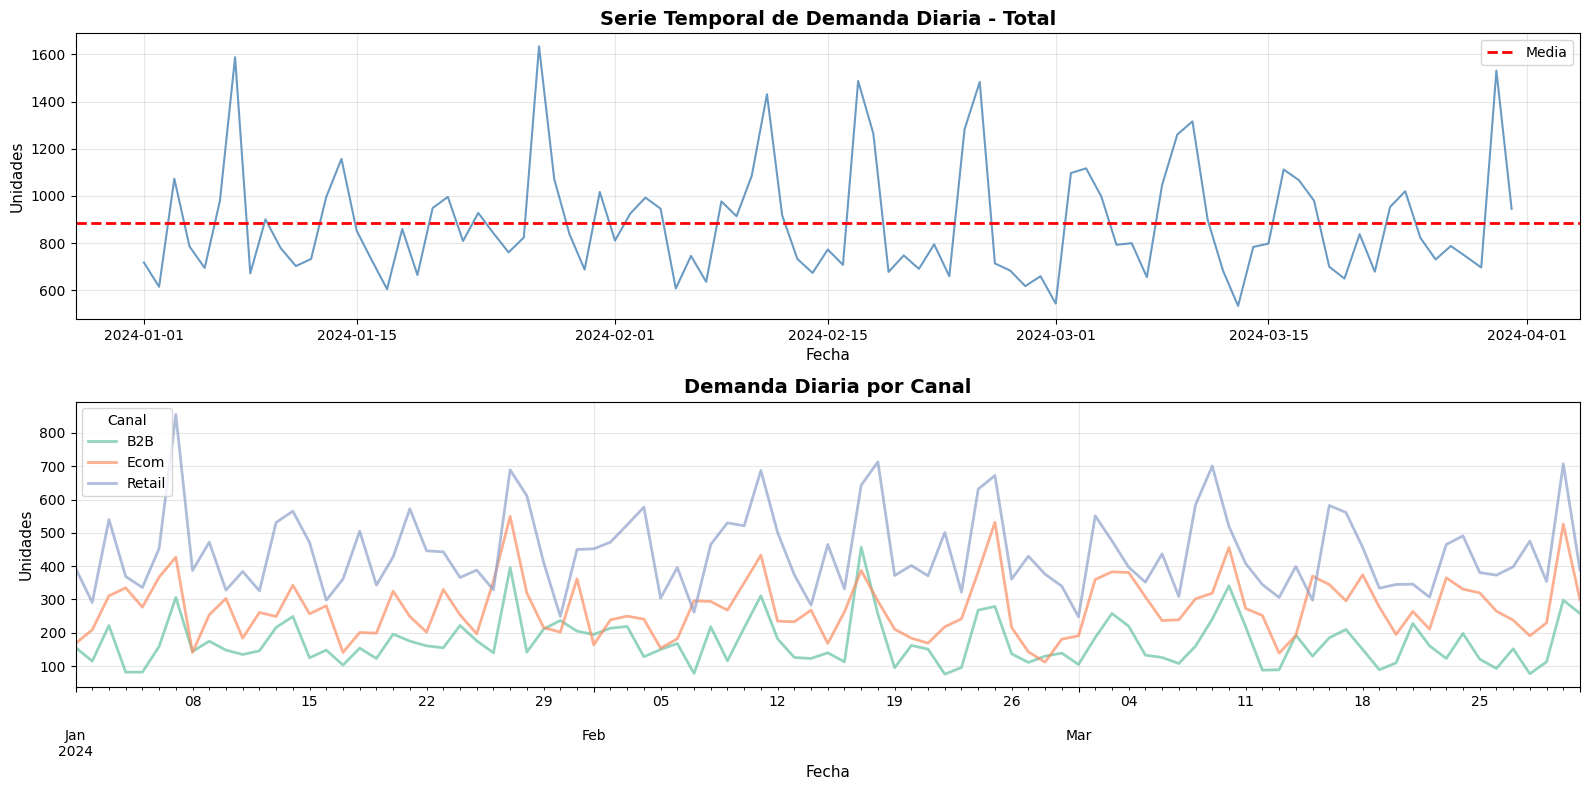


✅ Paso 1 completado: Datos cargados y visualizados


In [ ]:
## 📥 Paso 1: Cargar y Preparar Datos Temporales

# Cargar datos
data_path = _repo_root / 'data' / 'raw'
df_orders = pd.read_csv(data_path / 'orders.csv')
df_orders['date'] = pd.to_datetime(df_orders['date'])

print(f"📦 Datos cargados: {len(df_orders):,} órdenes")
print(f"   Período: {df_orders['date'].min()} a {df_orders['date'].max()}")
print(f"   Canales: {df_orders['channel'].unique()}")
print(f"   Columnas: {list(df_orders.columns)}")

# Agregar por fecha (serie diaria total)
ts_daily = df_orders.groupby('date')['qty'].sum().reset_index()
ts_daily = ts_daily.set_index('date').asfreq('D', fill_value=0)
ts_daily.columns = ['demand']

# Agregar por canal
ts_by_channel = df_orders.groupby(['date', 'channel'])['qty'].sum().reset_index()
ts_by_channel = ts_by_channel.pivot(index='date', columns='channel', values='qty').fillna(0)

print(f"\n📊 Serie temporal preparada:")
print(f"   Total días: {len(ts_daily)}")
print(f"   Demanda promedio: {ts_daily['demand'].mean():.1f} unidades/día")
print(f"   Desviación estándar: {ts_daily['demand'].std():.1f}")
print(f"   Coef. variación: {(ts_daily['demand'].std() / ts_daily['demand'].mean() * 100):.1f}%")

# Visualización inicial
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Serie completa
axes[0].plot(ts_daily.index, ts_daily['demand'], linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].set_title('Serie Temporal de Demanda Diaria - Total', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=11)
axes[0].set_ylabel('Unidades', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].axhline(y=ts_daily['demand'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
axes[0].legend()

# Por canal
ts_by_channel.plot(ax=axes[1], linewidth=2, alpha=0.7)
axes[1].set_title('Demanda Diaria por Canal', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=11)
axes[1].set_ylabel('Unidades', fontsize=11)
axes[1].legend(title='Canal', loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Paso 1 completado: Datos cargados y visualizados")

📊 COMPONENTES DESCOMPUESTOS:

1. TENDENCIA:
   Media: 890.2 unidades/día
   Crecimiento total: 5.7%
   Pendiente promedio: 0.58 unidades/día

2. ESTACIONALIDAD:
   Amplitud (pico-valle): 761.2 unidades
   % sobre media: 85.5%
   Día con mayor demanda: Sunday
   Día con menor demanda: Wednesday

3. RESIDUOS (Variación no explicada):
   Desv. estándar: 107.9
   % de varianza total: 19.6%


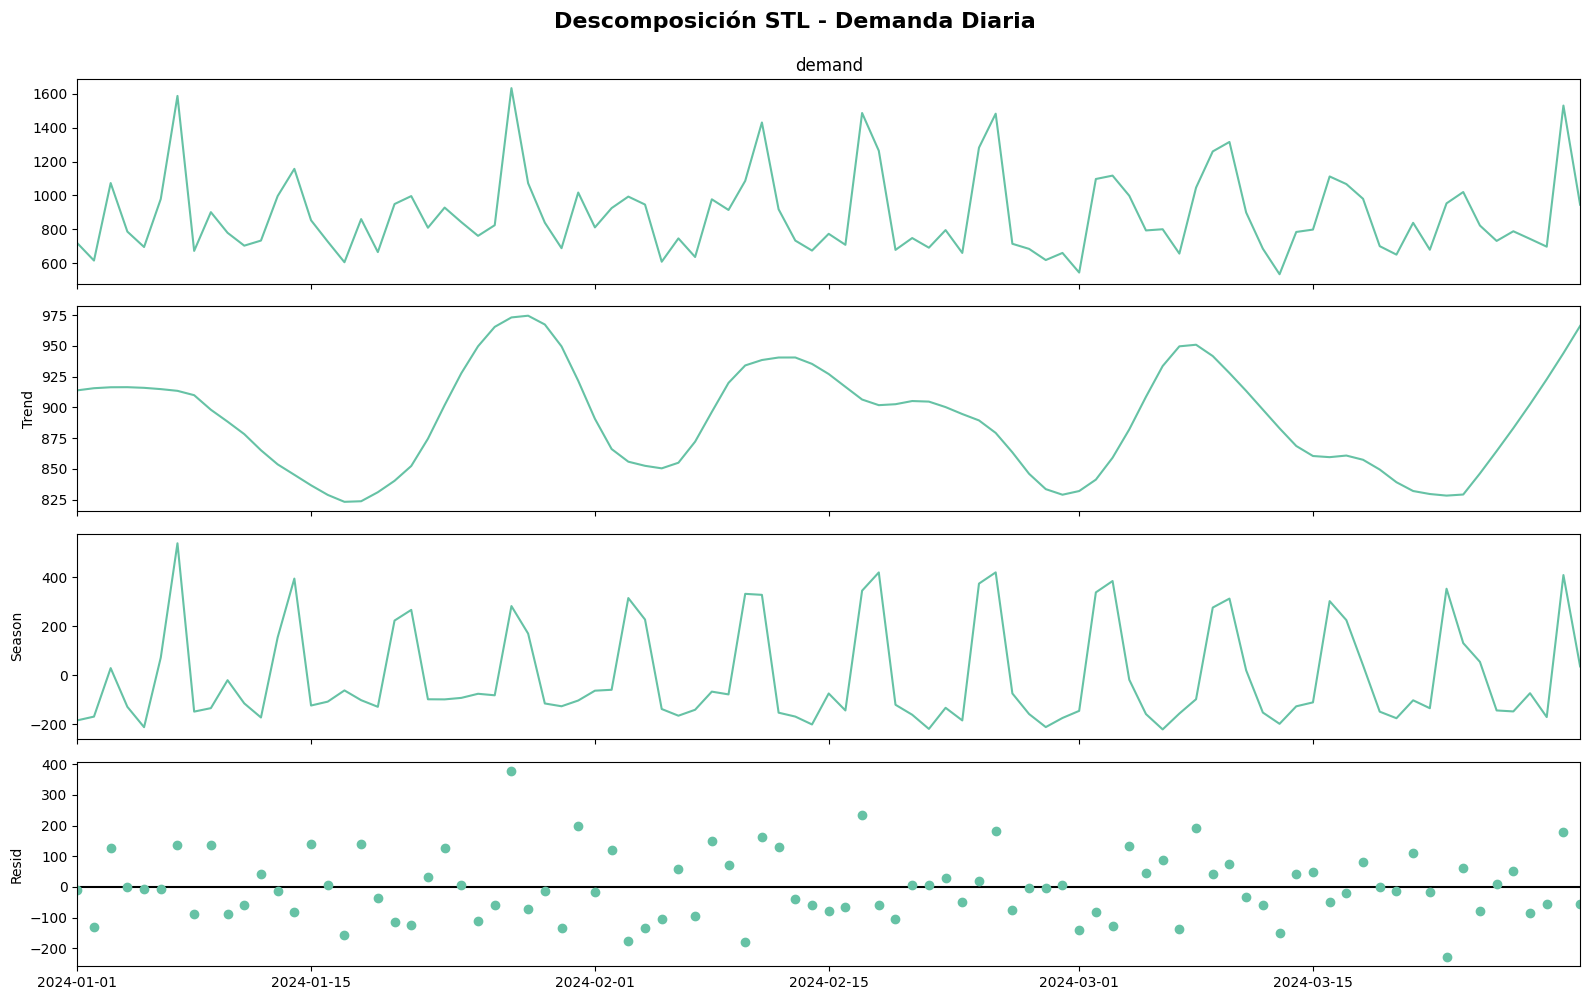


📊 VARIANZA EXPLICADA:
   Tendencia: 2.9%
   Estacionalidad: 70.5%
   Residuos: 19.6%

✅ Paso 2 completado: Descomposición STL realizada


In [ ]:
# 📚 CONCEPTO: STL (Seasonal-Trend decomposition using LOESS)
# STL descompone una serie temporal Y(t) en 3 componentes:
# Y(t) = T(t) + S(t) + R(t)
# - T(t): Tendencia (trend) - dirección de largo plazo
# - S(t): Estacionalidad (seasonal) - patrones repetitivos
# - R(t): Residuos (remainder) - variación no explicada

# 💡 INTERPRETACIÓN: ¿Qué nos dice cada componente?
# TENDENCIA:
# - Creciente: demanda aumenta sistemáticamente (expansión mercado, nuevos clientes)
# - Decreciente: demanda cae (productos maduros, competencia)
# - Plana: demanda estable (productos commodity)
# ESTACIONALIDAD:
# - Amplitud alta: fuerte dependencia de calendario (juguetes en Navidad)
# - Amplitud baja: demanda uniforme (productos básicos)
# RESIDUOS:
# - Desviación baja: serie predecible (buena para forecast)
# - Desviación alta: muchos eventos aleatorios (promociones, disrupciones)

# 🔍 TÉCNICA: Parámetros STL
# - seasonal: Número de observaciones en una temporada (7 = semana, 30 = mes, 365 = año)
# - period: Igual que seasonal (redundante pero requerido por statsmodels)
# - robust=True: Activar si hay outliers (reduce su influencia)
# - trend: Ventana de suavizado para tendencia (None = automático)

# 🎯 APLICACIÓN: Interpretación de varianza explicada
# Si tendencia explica 60% varianza → forecast a largo plazo es confiable
# Si estacionalidad explica 30% varianza → incorporar componente estacional en forecast
# Si residuos explican >40% varianza → serie muy errática, considerar:
#   * Variables exógenas (promociones, clima, competencia)
#   * Modelos más complejos (SARIMA, Prophet, LSTM)
#   * Segmentar por canal/categoría (puede haber múltiples estacionalidades)

# ⚠️ SUPUESTO: Estacionalidad semanal (period=7)
# Este código asume patrón semanal (ej: fin de semana vs días laborables).
# Para estacionalidad:
# - Mensual: period=30 (quincenas, fin de mes)
# - Anual: period=365 (temporadas, festivos)
# - Múltiple: aplicar STL jerárquico o MSTL (multiple seasonal)

## 🔍 Paso 2: Descomposición STL (Seasonal-Trend using LOESS)

# Aplicar STL decomposition con período semanal (7 días)
stl = STL(ts_daily['demand'], seasonal=7, period=7)
result_stl = stl.fit()

# Extraer componentes
trend = result_stl.trend
seasonal = result_stl.seasonal
resid = result_stl.resid

# Estadísticas de componentes
print("📊 COMPONENTES DESCOMPUESTOS:")
print(f"\n1. TENDENCIA:")
trend_start = trend.iloc[0]
if trend_start != 0:
    growth_pct = ((trend.iloc[-1] - trend_start) / trend_start * 100)
else:
    growth_pct = np.nan
print(f"   Media: {trend.mean():.1f} unidades/día")
print(f"   Crecimiento total: {growth_pct:.1f}%" if not np.isnan(growth_pct) else "   Crecimiento total: N/A")
print(f"   Pendiente promedio: {(trend.diff().mean()):.2f} unidades/día")

print(f"\n2. ESTACIONALIDAD:")
print(f"   Amplitud (pico-valle): {seasonal.max() - seasonal.min():.1f} unidades")
print(f"   % sobre media: {((seasonal.max() - seasonal.min()) / max(trend.mean(), 1e-6) * 100):.1f}%")
print(f"   Día con mayor demanda: {seasonal.idxmax().strftime('%A')}")
print(f"   Día con menor demanda: {seasonal.idxmin().strftime('%A')}")

print(f"\n3. RESIDUOS (Variación no explicada):")
print(f"   Desv. estándar: {resid.std():.1f}")
print(f"   % de varianza total: {(resid.var() / max(ts_daily['demand'].var(), 1e-6) * 100):.1f}%")

# Visualizar descomposición
fig = result_stl.plot()
fig.set_size_inches(16, 10)
fig.suptitle('Descomposición STL - Demanda Diaria', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Varianza explicada por cada componente
var_original = ts_daily['demand'].var()
var_trend = trend.var()
var_seasonal = seasonal.var()
var_resid = resid.var()

print(f"\n📊 VARIANZA EXPLICADA:")
print(f"   Tendencia: {(var_trend / max(var_original, 1e-6) * 100):.1f}%")
print(f"   Estacionalidad: {(var_seasonal / max(var_original, 1e-6) * 100):.1f}%")
print(f"   Residuos: {(var_resid / max(var_original, 1e-6) * 100):.1f}%")

print("\n✅ Paso 2 completado: Descomposición STL realizada")


📊 ÍNDICES DE ESTACIONALIDAD (100 = media anual)

Día          Índice     Interpretación
--------------------------------------------------
Lunes          90.7     📉 BAJA
Martes         83.5     📉 BAJA
Miércoles      84.6     📉 BAJA
Jueves         87.8     📉 BAJA
Viernes        85.0     📉 BAJA
Sábado        132.8     📈 ALTA
Domingo       133.4     📈 ALTA

📅 ESTACIONALIDAD MENSUAL:
Ene:   98.2  ➖ NORMAL
Feb:   99.4  ➖ NORMAL
Mar:  101.4  ➖ NORMAL


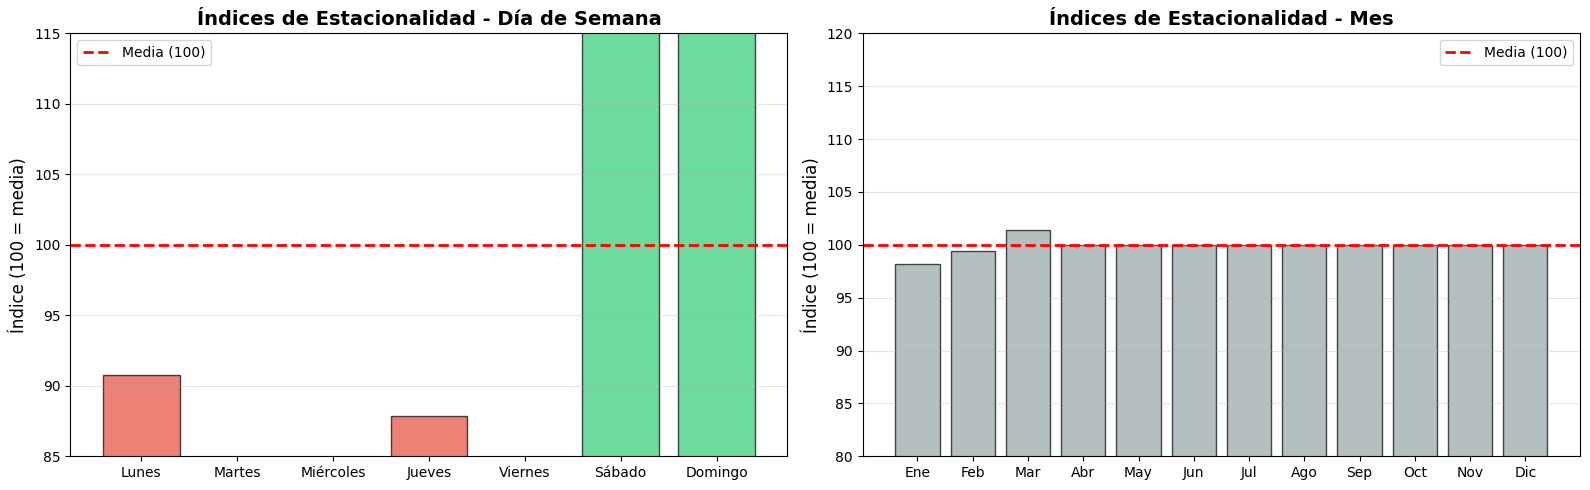


✅ Paso 3 completado: Índices de estacionalidad calculados


In [13]:
## 📈 Paso 3: Cálculo de Índices de Estacionalidad

# Calcular demanda promedio anual
mean_annual = ts_daily['demand'].mean()

# Extraer el componente estacional y calcular índices
seasonal_index = (seasonal / mean_annual * 100 + 100).round(2)

print("📊 ÍNDICES DE ESTACIONALIDAD (100 = media anual)")
print(f"\n{'Día':<12} {'Índice':<10} {'Interpretación'}")
print("-" * 50)

# Agrupar por día de la semana
ts_daily['dow'] = ts_daily.index.dayofweek
ts_daily['seasonal_component'] = seasonal

seasonal_by_dow = ts_daily.groupby('dow')['seasonal_component'].mean()
days_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

for i, day_name in enumerate(days_names):
    idx = (seasonal_by_dow.iloc[i] / mean_annual * 100 + 100)
    interpretation = "📈 ALTA" if idx > 105 else "📉 BAJA" if idx < 95 else "⚖️  NORMAL"
    print(f"{day_name:<12} {idx:>6.1f}     {interpretation}")

# Índices por mes
ts_daily['month'] = ts_daily.index.month
seasonal_by_month = ts_daily.groupby('month')['seasonal_component'].mean()

print(f"\n📅 ESTACIONALIDAD MENSUAL:")
months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
for i, month_name in enumerate(months, start=1):
    if i in seasonal_by_month.index:
        idx = (seasonal_by_month.loc[i] / mean_annual * 100 + 100)
        interpretation = "🔥 PICO" if idx > 110 else "❄️  VALLE" if idx < 90 else "➖ NORMAL"
        print(f"{month_name}: {idx:>6.1f}  {interpretation}")

# Visualización de índices
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Índices por día de semana
dow_indices = [(seasonal_by_dow.iloc[i] / mean_annual * 100 + 100) for i in range(7)]
colors_dow = ['#2ecc71' if x > 105 else '#e74c3c' if x < 95 else '#95a5a6' for x in dow_indices]
axes[0].bar(days_names, dow_indices, color=colors_dow, alpha=0.7, edgecolor='black')
axes[0].axhline(100, color='red', linestyle='--', linewidth=2, label='Media (100)')
axes[0].set_title('Índices de Estacionalidad - Día de Semana', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Índice (100 = media)', fontsize=12)
axes[0].set_ylim(85, 115)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Índices por mes
month_indices = [(seasonal_by_month.loc[i] / mean_annual * 100 + 100) if i in seasonal_by_month.index else 100 for i in range(1, 13)]
colors_month = ['#2ecc71' if x > 110 else '#e74c3c' if x < 90 else '#95a5a6' for x in month_indices]
axes[1].bar(months, month_indices, color=colors_month, alpha=0.7, edgecolor='black')
axes[1].axhline(100, color='red', linestyle='--', linewidth=2, label='Media (100)')
axes[1].set_title('Índices de Estacionalidad - Mes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Índice (100 = media)', fontsize=12)
axes[1].set_ylim(80, 120)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Paso 3 completado: Índices de estacionalidad calculados")

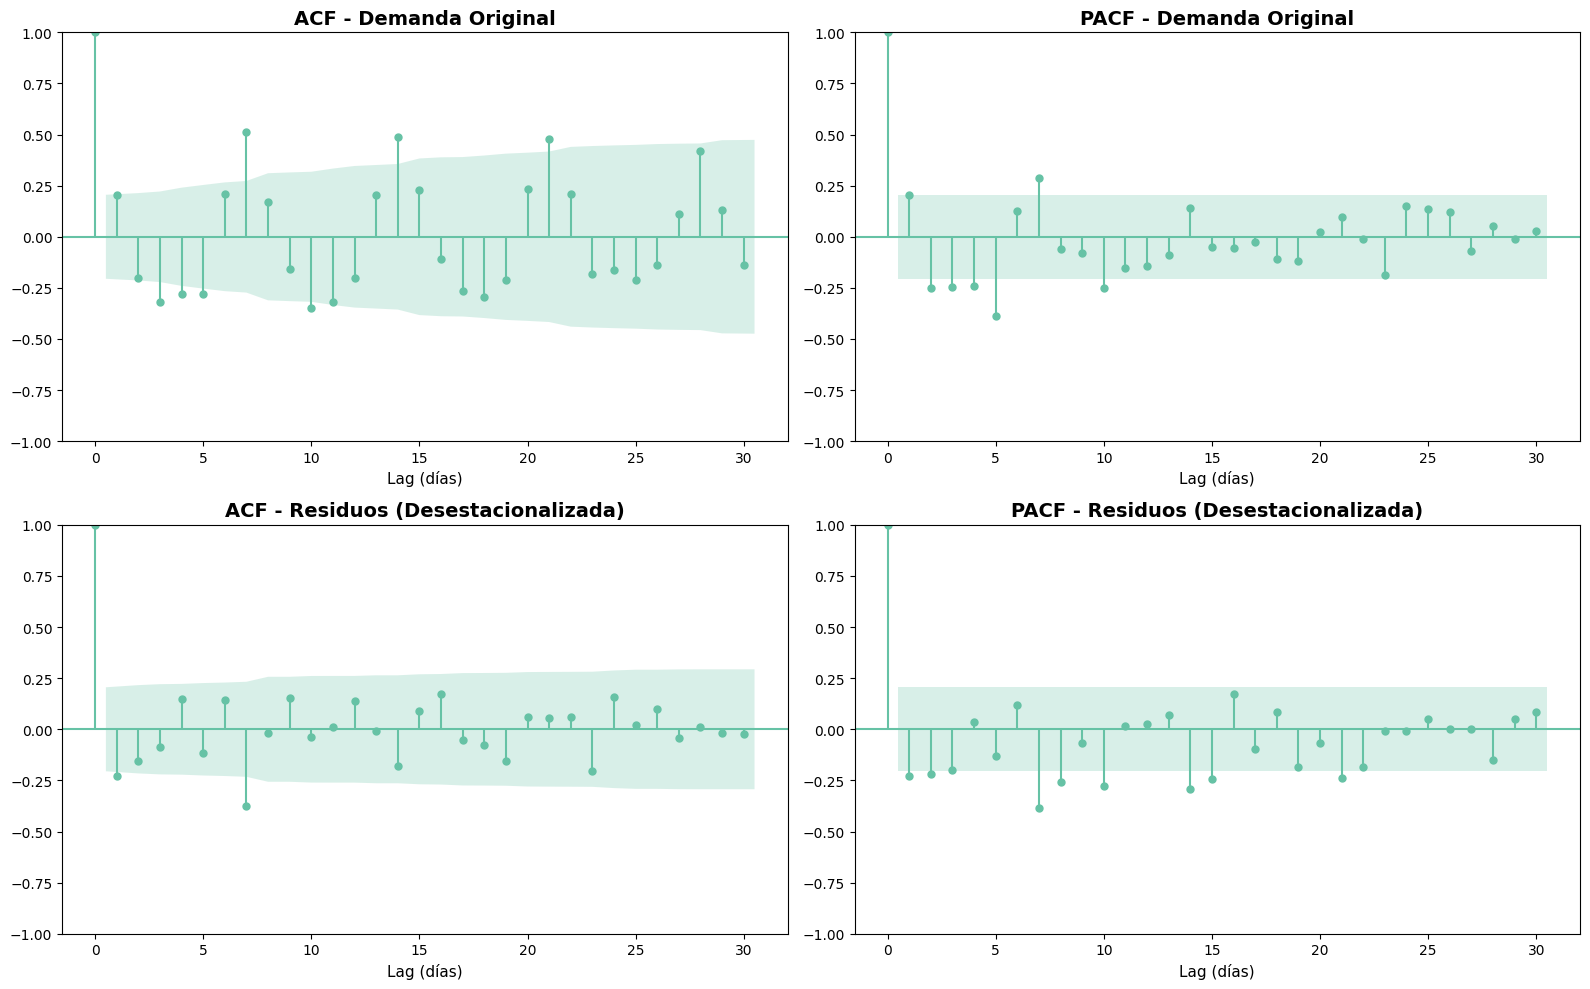

📊 AUTOCORRELACIONES SIGNIFICATIVAS:

Lags con autocorrelación significativa (α=0.05): 17
Primeros 10 lags: [3, 4, 5, 6, 7, 10, 11, 14, 15, 17]

Interpretación:
  • Lag 7 presente: ✅ SÍ → Patrón semanal
  • Lag 30 presente: ❌ NO → Patrón mensual

🔬 TEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller):
  ADF Statistic: -4.2162
  p-value: 0.0006
  Conclusión: ✅ ESTACIONARIA (α=0.05)

🔬 TEST SOBRE RESIDUOS (Después de desestacionalizar):
  ADF Statistic: -5.9091
  p-value: 0.0000
  Conclusión: ✅ ESTACIONARIA (α=0.05)

✅ Paso 4 completado: Análisis de autocorrelación realizado


In [14]:
## 🔬 Paso 4: Análisis de Autocorrelación (ACF/PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear figura con ACF y PACF
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF/PACF para la serie original
plot_acf(ts_daily['demand'].dropna(), lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Demanda Original', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Lag (días)', fontsize=11)

plot_pacf(ts_daily['demand'].dropna(), lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Demanda Original', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Lag (días)', fontsize=11)

# ACF/PACF para los residuos (serie desestacionalizada)
plot_acf(resid.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Residuos (Desestacionalizada)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Lag (días)', fontsize=11)

plot_pacf(resid.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Residuos (Desestacionalizada)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Lag (días)', fontsize=11)

plt.tight_layout()
plt.show()

# Calcular autocorrelaciones significativas
from statsmodels.tsa.stattools import acf
acf_values = acf(ts_daily['demand'].dropna(), nlags=30)
significant_lags = [i for i in range(1, 31) if abs(acf_values[i]) > 1.96 / np.sqrt(len(ts_daily))]

print("📊 AUTOCORRELACIONES SIGNIFICATIVAS:")
print(f"\nLags con autocorrelación significativa (α=0.05): {len(significant_lags)}")
print(f"Primeros 10 lags: {significant_lags[:10]}")
print(f"\nInterpretación:")
print(f"  • Lag 7 presente: {'✅ SÍ' if 7 in significant_lags else '❌ NO'} → Patrón semanal")
print(f"  • Lag 30 presente: {'✅ SÍ' if 30 in significant_lags else '❌ NO'} → Patrón mensual")

# Test de estacionariedad (Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts_daily['demand'].dropna())

print(f"\n🔬 TEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller):")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Conclusión: {'✅ ESTACIONARIA' if adf_result[1] < 0.05 else '❌ NO ESTACIONARIA'} (α=0.05)")

# Test sobre residuos
adf_resid = adfuller(resid.dropna())
print(f"\n🔬 TEST SOBRE RESIDUOS (Después de desestacionalizar):")
print(f"  ADF Statistic: {adf_resid[0]:.4f}")
print(f"  p-value: {adf_resid[1]:.4f}")
print(f"  Conclusión: {'✅ ESTACIONARIA' if adf_resid[1] < 0.05 else '❌ NO ESTACIONARIA'} (α=0.05)")

print("\n✅ Paso 4 completado: Análisis de autocorrelación realizado")

📊 DIVISIÓN DE DATOS:
  Training: 2024-01-01 a 2024-03-12 (72 días)
  Test: 2024-03-13 a 2024-03-31 (19 días)

📊 COMPARACIÓN DE MODELOS:
              model        MAE       RMSE      MAPE
Baseline (Promedio) 174.238304 219.302769 21.032304
 STL Descomposición 143.538174 171.423629 16.575339
       Holt-Winters 125.951747 163.489269 14.497461

🏆 MEJOR MODELO: Holt-Winters (MAPE = 14.50% si aplica)


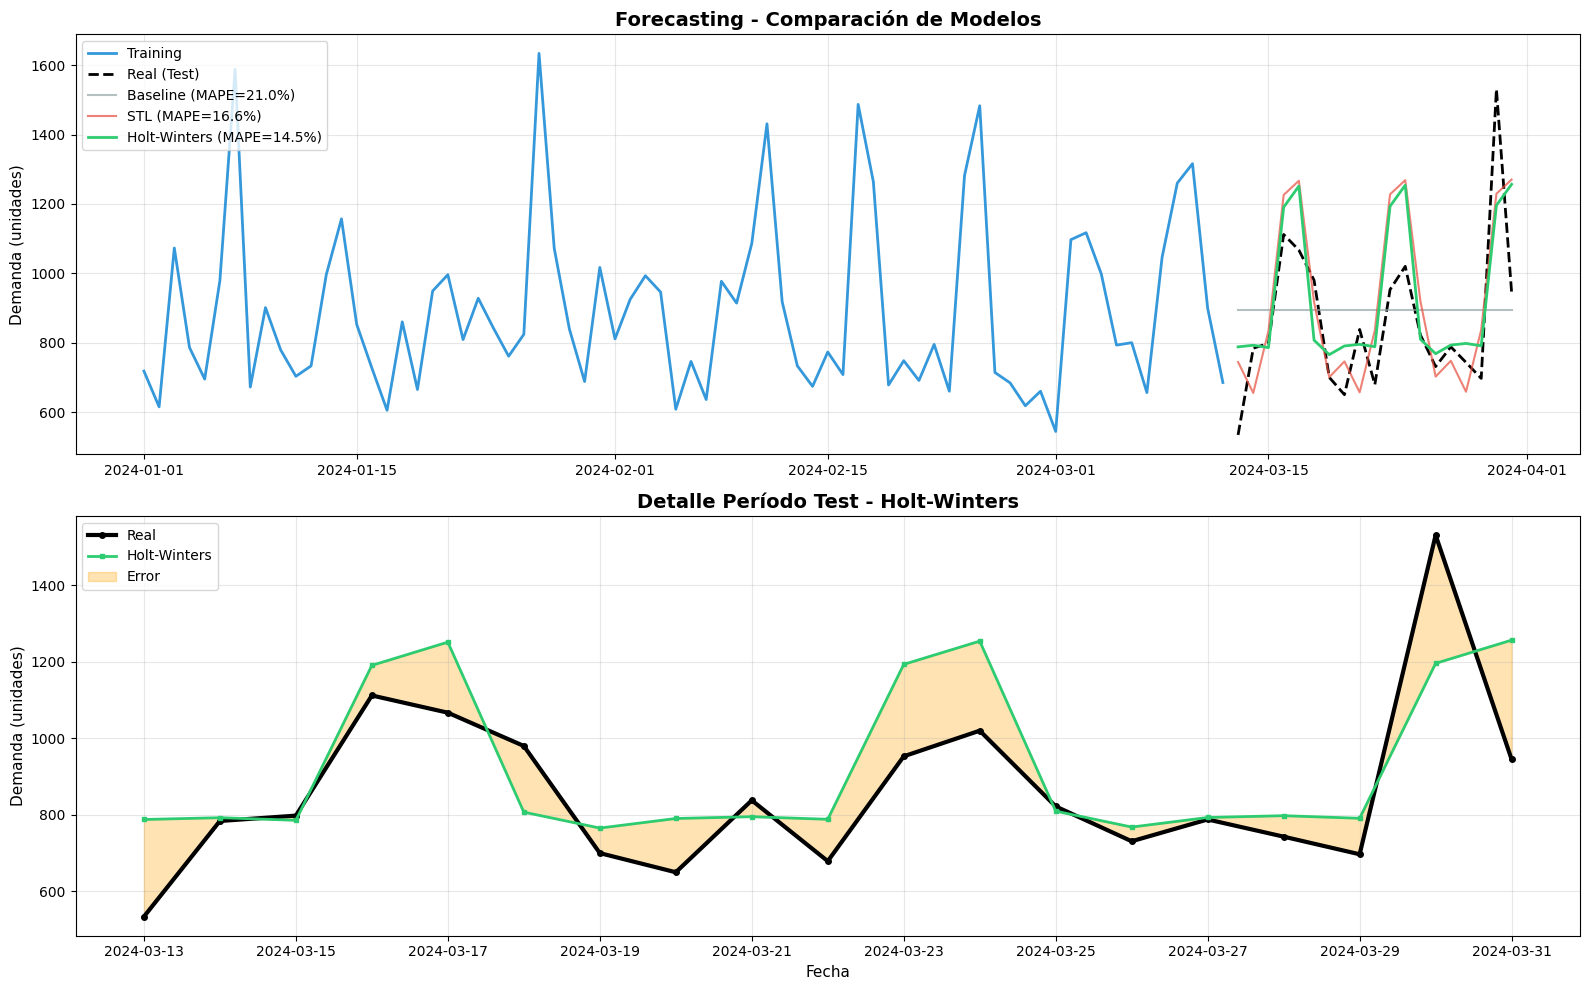


💰 IMPACTO DE MEJORA:
  MAPE Actual: 35.0%
  MAPE Mejorado: 14.50%
  Reducción: 20.50 puntos porcentuales
  Mejora relativa: 58.6%

✅ Paso 5 completado: Forecasting con ajuste estacional realizado


In [15]:
## 🎯 Paso 5: Forecasting con Ajuste Estacional

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Crear conjunto de entrenamiento (80%) y prueba (20%)
train_size = int(len(ts_daily) * 0.8)
train = ts_daily[:train_size].copy()
test = ts_daily[train_size:].copy()

print(f"📊 DIVISIÓN DE DATOS:")
print(f"  Training: {train.index[0].strftime('%Y-%m-%d')} a {train.index[-1].strftime('%Y-%m-%d')} ({len(train)} días)")
print(f"  Test: {test.index[0].strftime('%Y-%m-%d')} a {test.index[-1].strftime('%Y-%m-%d')} ({len(test)} días)")

# Modelo 1: Forecast ingenuo (baseline)
# Simplemente usar el promedio histórico
baseline_forecast = np.full(len(test), train['demand'].mean())

# Modelo 2: Forecast con estacionalidad
# Usar STL para predecir con componentes
stl_train = STL(train['demand'], seasonal=7, period=7).fit()

# Extrapolar tendencia linealmente
trend_train = stl_train.trend.dropna()
x_train = np.arange(len(trend_train))
coeffs = np.polyfit(x_train, trend_train, 1)
x_forecast = np.arange(len(trend_train), len(trend_train) + len(test))
trend_forecast = np.polyval(coeffs, x_forecast)

# Repetir componente estacional (patrón de 7 días)
seasonal_pattern = stl_train.seasonal[-7:].values
seasonal_forecast = np.tile(seasonal_pattern, int(np.ceil(len(test) / 7)))[:len(test)]

# Forecast final = trend + seasonal
seasonal_forecast_values = trend_forecast + seasonal_forecast

# Modelo 3: Suavizado exponencial simple con estacionalidad
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_hw = ExponentialSmoothing(
    train['demand'],
    seasonal_periods=7,
    trend='add',
    seasonal='add'
).fit()
hw_forecast = model_hw.forecast(len(test))

# Calcular métricas (robustas a demanda = 0)
def calculate_metrics(actual, predicted, model_name):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mask = actual != 0
    if mask.any():
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    else:
        mape = np.nan
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

metrics = []
metrics.append(calculate_metrics(test['demand'], baseline_forecast, 'Baseline (Promedio)'))
metrics.append(calculate_metrics(test['demand'], seasonal_forecast_values, 'STL Descomposición'))
metrics.append(calculate_metrics(test['demand'], hw_forecast, 'Holt-Winters'))

# Mostrar resultados
df_metrics = pd.DataFrame(metrics)
print(f"\n📊 COMPARACIÓN DE MODELOS:")
print(df_metrics.to_string(index=False))

# Encontrar mejor modelo
best_row = df_metrics.loc[df_metrics['MAPE'].idxmin()] if df_metrics['MAPE'].notna().any() else df_metrics.loc[df_metrics['RMSE'].idxmin()]
best_model = best_row['model']
best_mape = best_row['MAPE']
print(f"\n🏆 MEJOR MODELO: {best_model} (MAPE = {best_mape:.2f}% si aplica)")

# Visualización de forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Serie completa con forecasts
axes[0].plot(train.index, train['demand'], label='Training', color='#3498db', linewidth=2)
axes[0].plot(test.index, test['demand'], label='Real (Test)', color='black', linewidth=2, linestyle='--')
axes[0].plot(test.index, baseline_forecast, label=f'Baseline (MAPE={metrics[0]["MAPE"]:.1f}%)', color='#95a5a6', alpha=0.7)
axes[0].plot(test.index, seasonal_forecast_values, label=f'STL (MAPE={metrics[1]["MAPE"]:.1f}%)', color='#e74c3c', alpha=0.7)
axes[0].plot(test.index, hw_forecast, label=f'Holt-Winters (MAPE={metrics[2]["MAPE"]:.1f}%)', color='#2ecc71', linewidth=2)
axes[0].set_title('Forecasting - Comparación de Modelos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Demanda (unidades)', fontsize=11)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# Gráfico 2: Zoom en período de test
axes[1].plot(test.index, test['demand'], label='Real', color='black', linewidth=3, marker='o', markersize=4)
axes[1].plot(test.index, hw_forecast, label=f'{best_model}', color='#2ecc71', linewidth=2, marker='s', markersize=3)
axes[1].fill_between(test.index, test['demand'], hw_forecast, alpha=0.3, color='orange', label='Error')
axes[1].set_title(f'Detalle Período Test - {best_model}', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Demanda (unidades)', fontsize=11)
axes[1].set_xlabel('Fecha', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cálculo de mejora vs situación actual
current_mape = 35.0  # MAPE actual del negocio
improved_mape = best_mape if pd.notna(best_mape) else np.nan
reduction = current_mape - improved_mape if pd.notna(improved_mape) else np.nan

print(f"\n💰 IMPACTO DE MEJORA:")
print(f"  MAPE Actual: {current_mape:.1f}%")
if pd.notna(improved_mape):
    print(f"  MAPE Mejorado: {improved_mape:.2f}%")
else:
    print(f"  MAPE Mejorado: N/A")
    
if pd.notna(reduction):
    print(f"  Reducción: {reduction:.2f} puntos porcentuales")
    print(f"  Mejora relativa: {(reduction / current_mape * 100):.1f}%")
else:
    print(f"  Reducción: N/A")
    print(f"  Mejora relativa: N/A")

print("\n✅ Paso 5 completado: Forecasting con ajuste estacional realizado")

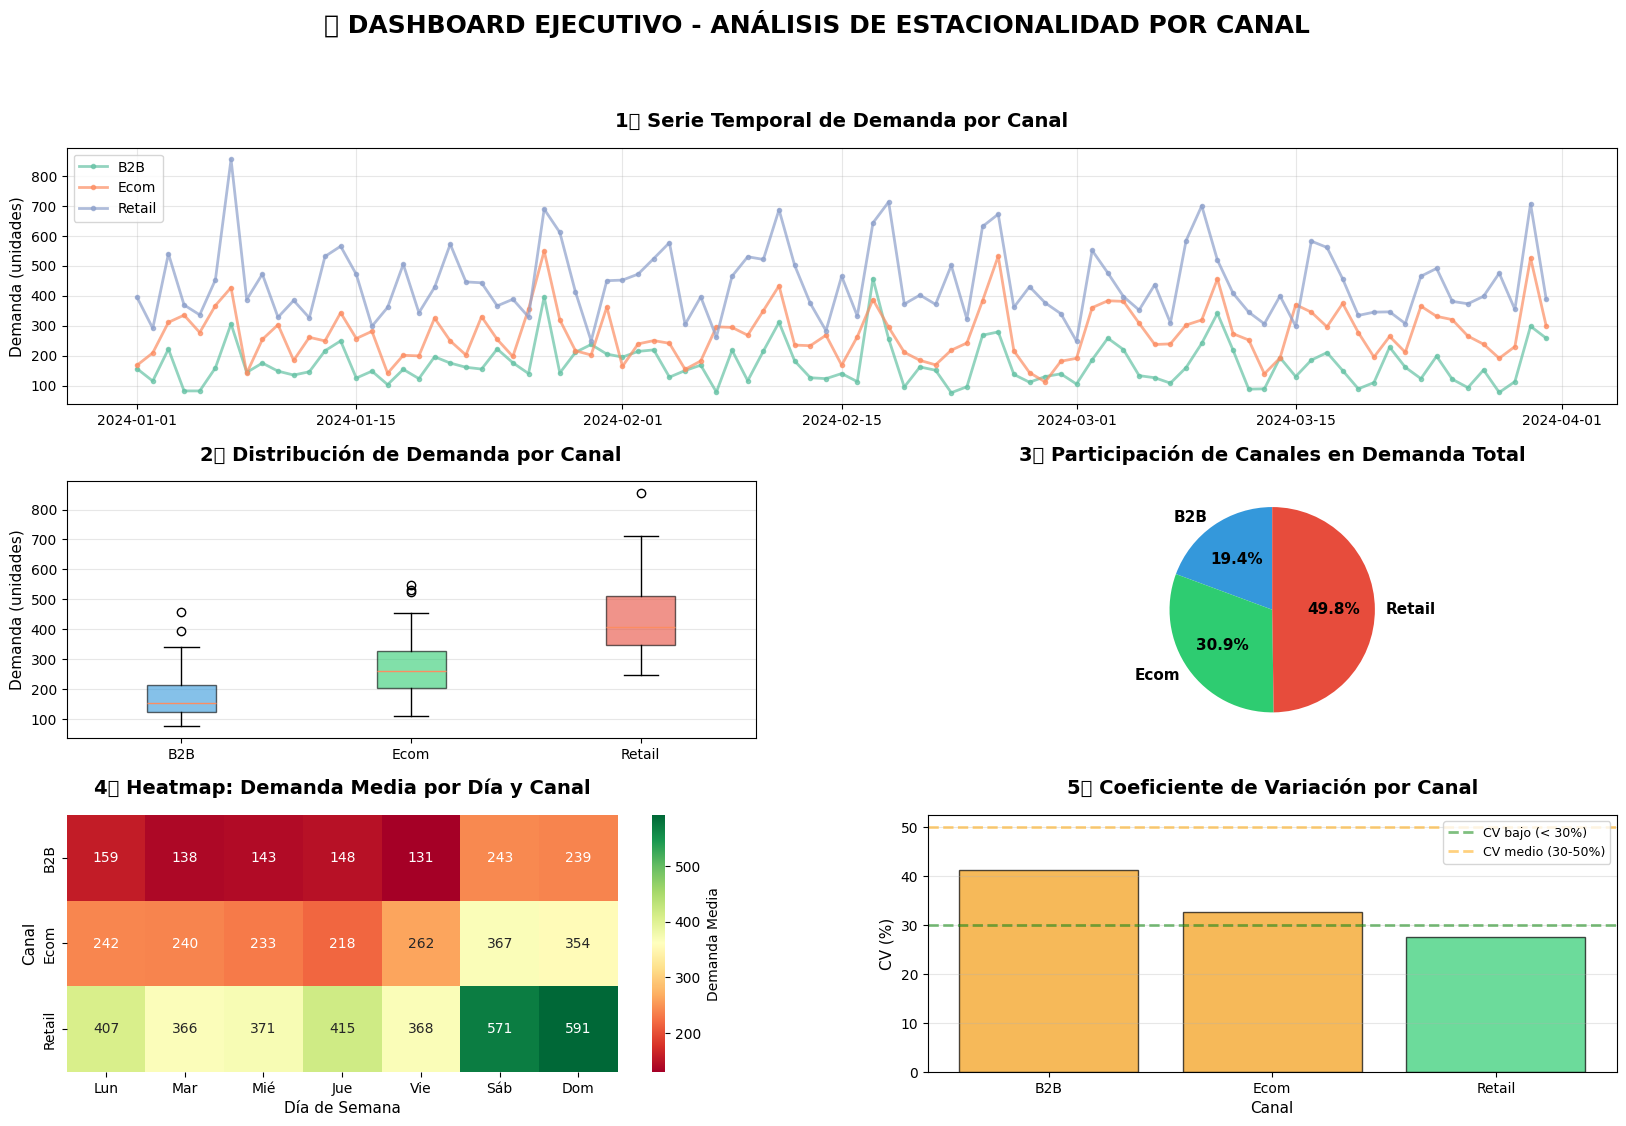

📊 RESUMEN ESTADÍSTICO POR CANAL:


B2B:
  Media diaria: 171.6 unidades
  Desv. estándar: 70.9
  CV: 41.3%
  Min: 76 | Max: 457
  Participación: 19.4%

ECOM:
  Media diaria: 273.7 unidades
  Desv. estándar: 89.3
  CV: 32.6%
  Min: 112 | Max: 549
  Participación: 30.9%

RETAIL:
  Media diaria: 441.4 unidades
  Desv. estándar: 122.1
  CV: 27.7%
  Min: 248 | Max: 855
  Participación: 49.8%

✅ Paso 6 completado: Dashboard ejecutivo generado


In [16]:
## 📊 Paso 6: Dashboard Ejecutivo - Estacionalidad por Canal

# Preparar datos agregados por canal
# (usar df_orders y columna 'date' del dataset cargado en el Paso 1)
ts_channel = df_orders.groupby(['date', 'channel']).agg({'qty': 'sum'}).reset_index()
ts_channel.columns = ['date', 'channel', 'demand']

# Crear dashboard con 6 paneles
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# Panel 1: Serie temporal por canal
ax1 = fig.add_subplot(gs[0, :])
for channel in ts_channel['channel'].unique():
    channel_data = ts_channel[ts_channel['channel'] == channel]
    ax1.plot(channel_data['date'], channel_data['demand'], label=channel, linewidth=2, marker='o', markersize=3, alpha=0.7)
ax1.set_title('1️⃣ Serie Temporal de Demanda por Canal', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Demanda (unidades)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(alpha=0.3)

# Panel 2: Distribución de demanda por canal (boxplot)
ax2 = fig.add_subplot(gs[1, 0])
channels = ts_channel['channel'].unique()
channel_demands = [ts_channel[ts_channel['channel'] == ch]['demand'].values for ch in channels]
bp = ax2.boxplot(channel_demands, labels=channels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(channels)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_title('2️⃣ Distribución de Demanda por Canal', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Demanda (unidades)', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Panel 3: Participación por canal (pie chart)
ax3 = fig.add_subplot(gs[1, 1])
channel_totals = ts_channel.groupby('channel')['demand'].sum()
colors_pie = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(channel_totals)]
wedges, texts, autotexts = ax3.pie(
    channel_totals, 
    labels=channel_totals.index, 
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax3.set_title('3️⃣ Participación de Canales en Demanda Total', fontsize=14, fontweight='bold', pad=15)

# Panel 4: Heatmap estacionalidad semanal por canal
ax4 = fig.add_subplot(gs[2, 0])
ts_channel['dow'] = pd.to_datetime(ts_channel['date']).dt.dayofweek
heatmap_data = ts_channel.pivot_table(values='demand', index='channel', columns='dow', aggfunc='mean')
heatmap_data.columns = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn', cbar_kws={'label': 'Demanda Media'}, ax=ax4)
ax4.set_title('4️⃣ Heatmap: Demanda Media por Día y Canal', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Día de Semana', fontsize=11)
ax4.set_ylabel('Canal', fontsize=11)

# Panel 5: Coeficiente de variación por canal
ax5 = fig.add_subplot(gs[2, 1])
cv_by_channel = ts_channel.groupby('channel').agg({'demand': lambda x: (x.std() / x.mean() * 100)}).reset_index()
cv_by_channel.columns = ['channel', 'CV']
colors_cv = ['#2ecc71' if cv < 30 else '#f39c12' if cv < 50 else '#e74c3c' for cv in cv_by_channel['CV']]
ax5.bar(cv_by_channel['channel'], cv_by_channel['CV'], color=colors_cv, alpha=0.7, edgecolor='black')
ax5.axhline(30, color='green', linestyle='--', linewidth=2, alpha=0.5, label='CV bajo (< 30%)')
ax5.axhline(50, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='CV medio (30-50%)')
ax5.set_title('5️⃣ Coeficiente de Variación por Canal', fontsize=14, fontweight='bold', pad=15)
ax5.set_ylabel('CV (%)', fontsize=11)
ax5.set_xlabel('Canal', fontsize=11)
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

plt.suptitle('📊 DASHBOARD EJECUTIVO - ANÁLISIS DE ESTACIONALIDAD POR CANAL', 
             fontsize=18, fontweight='bold', y=0.995)
plt.show()

# Resumen estadístico
print("📊 RESUMEN ESTADÍSTICO POR CANAL:")
print("\n" + "="*70)
for channel in channels:
    ch_data = ts_channel[ts_channel['channel'] == channel]['demand']
    print(f"\n{channel.upper()}:")
    print(f"  Media diaria: {ch_data.mean():.1f} unidades")
    print(f"  Desv. estándar: {ch_data.std():.1f}")
    print(f"  CV: {(ch_data.std() / ch_data.mean() * 100):.1f}%")
    print(f"  Min: {ch_data.min():.0f} | Max: {ch_data.max():.0f}")
    print(f"  Participación: {(ch_data.sum() / ts_channel['demand'].sum() * 100):.1f}%")

print("\n✅ Paso 6 completado: Dashboard ejecutivo generado")